In [2]:
import numpy as np
import numba as nb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import cached_property
import scienceplots

plt.style.use(["science"])

In [20]:
class QuantumSystem:
    def __init__(self, n_qubits):
        self.n_qubits = n_qubits
        self.N = 2**n_qubits
        self.uniform_superposition = self.normalise(np.array([complex(1, 0)] * 2**(self.n_qubits)))
        self.register = self.uniform_superposition.copy()

    def normalise(self, system):
        return system / np.sqrt(np.sum(np.abs(system)**2))

class QuantumSearch(QuantumSystem):
    def __init__(self, n_qubits, oracle):
        self.n_qubits = n_qubits
        self.oracle = oracle
        QuantumSystem.__init__(self, self.n_qubits)

    @cached_property
    def oracle_operator(self):
        a = np.eye(2**self.n_qubits)
        mask = np.array([self.oracle(i) for i in range(2**self.n_qubits)])
        a[mask] *= -1
        return a

    @cached_property
    def diffusion_operator(self):
        s = self.uniform_superposition.flatten()[np.newaxis].T
        return 2 * np.matmul(s, s.T) - np.eye(2**self.n_qubits)
    
    def step(self):
        self.register = np.multiply(np.diag(self.oracle_operator), self.register)
        self.register = np.matmul(self.diffusion_operator, self.register)
    
    def measurement(self):
        return np.searchsorted(np.cumsum(np.abs(self.register)**2), np.random.random())

Text(0, 0.5, 'Probability')

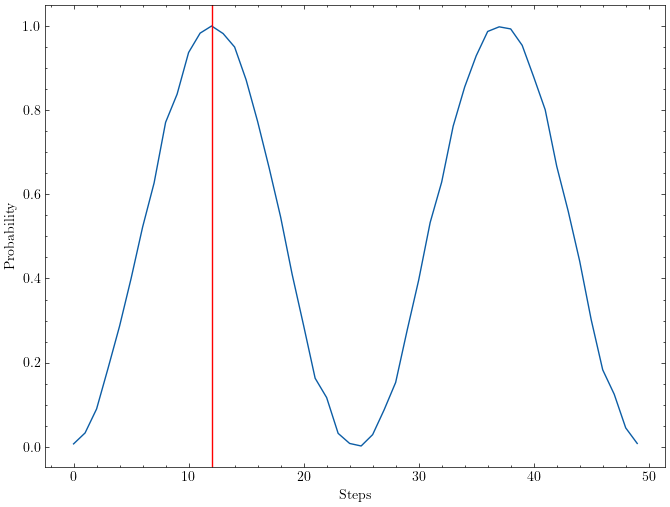

In [21]:
def oracle(x):
    return (x > 2) and (x & (x - 1) == 0) and (x & (x + 18) == 0)

samples = 1000
steps = 50

counts = np.zeros((steps), dtype=int)

for i in range(samples):
    qsearch = QuantumSearch(n_qubits=8, oracle=oracle)
    for j in range(steps):
        if qsearch.measurement() == 16:
            counts[j] += 1
        qsearch.step()
counts = counts / samples

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(counts)
plt.axvline(np.floor(np.pi / 4 * np.sqrt(qsearch.N)), c="r")
plt.xlabel("Steps")
plt.ylabel("Probability")